# Aquila

In [54]:
import aplpy
from astropy.io import fits
%pylab inline
#%matplotlib widget
#plt.style.use(['dark_background'])
path = '/user/workdir/albouyg/Gouldbelt/Aquila/'
name = 'aquilaM2'

Populating the interactive namespace from numpy and matplotlib


## Read and prepare the map

In [55]:
figfile = path + 'HGBS_' + name + '_column_density_map.fits'

In [56]:
#Read map
HDU = fits.open(figfile)
im = HDU[0].data
header = HDU[0].header

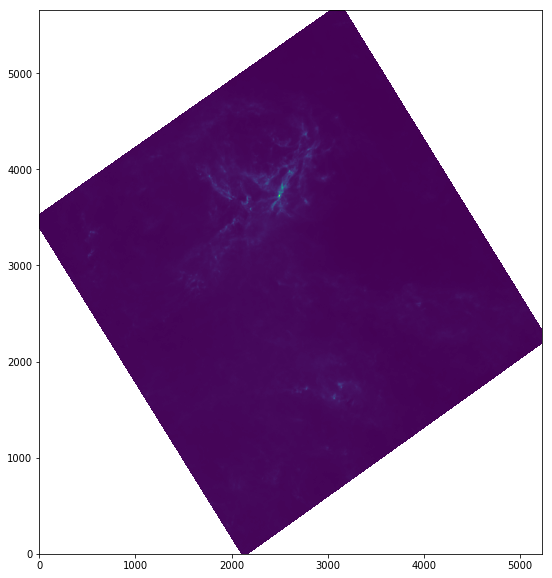

In [57]:
figure(figsize=(10,10))
imshow(im,origin='bottom')

In [58]:
header

SIMPLE  =                    T / Written by IDL:  Mon Jul 27 12:24:31 2015      
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 5233 / length of data axis 1                          
NAXIS2  =                 5657 / length of data axis 2                          
COMMENT   Science data image                                                    
CREATOR = 'IDL     '           / FITS file creator                              
TELESCOP= 'Herschel Space Observatory' / Name of telescope                      
INSTRUME= 'SPIRE/PACS'         / Herschel instrument                            
PROPOSAL= 'KPGT_pandre_1'      / Herschel proposal ID                           
PRTITLE = 'Herschel Gould Belt Survey (HGBS)' / Program Title                   
COMMENT   Reference publication of the survey: Andre' et al. (2010)             
COMMENT   bibcode: 2010A&A..

In [59]:
import reproject as proj

In [60]:
hdproj = header.copy()

ratio = 0.00388889/0.00083333333333333

#Change pixel resolution
hdproj['CDELT1'] = -0.00388889
hdproj['CDELT2'] = 0.00388889
hdproj['CRPIX1'] = header['CRPIX1']/ratio
hdproj['CRPIX2'] = header['CRPIX2']/ratio
hdproj['NAXIS1'] = np.int(header['NAXIS1']/ratio)
hdproj['NAXIS2'] = np.int(header['NAXIS2']/ratio)
#Rotate the map
hdproj['CROTA1'] = 58.1053
hdproj['CROTA2'] = 58.1053


improj = proj.reproject_exact(HDU,hdproj)
improjnp = np.asarray(improj)
fits.writeto(path + 'HGBS_' + name + '_column_density_map_rebin_rot.fits',improjnp[0,:,:], hdproj, overwrite=True)

In [61]:
from pywavan import powspec, fan_trans, apodize, padding, subfits, gauss_beam

INFO: Auto-setting vmin to  2.415e+20 [aplpy.core]
INFO: Auto-setting vmax to  2.505e+22 [aplpy.core]


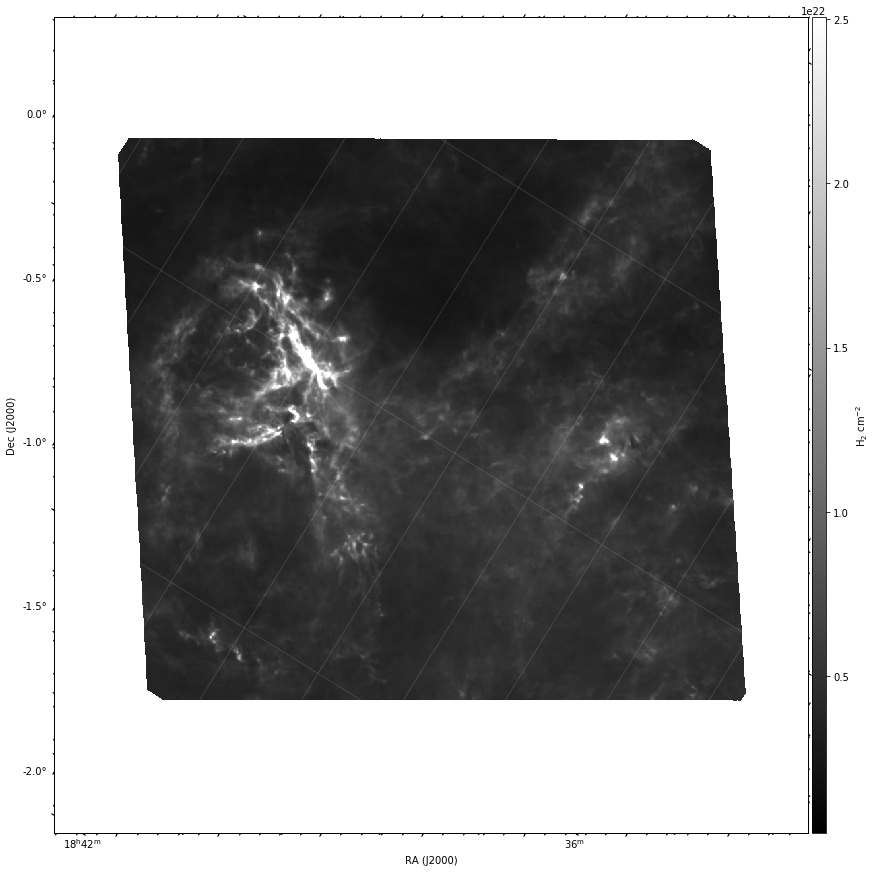

In [62]:
fig_all = plt.figure(1, figsize=(15,15))
fig = aplpy.FITSFigure(path + 'HGBS_' + name + '_column_density_map_rebin_rot.fits',figure=fig_all)
fig.show_colorscale(cmap='gray')
#fig.tick_labels.set_xformat('hh')
fig.tick_labels.set_yformat('dd.d')
#fig.ticks.set_xspacing(15)  # degrees
fig.ticks.set_yspacing(0.5)  # degrees
fig.add_colorbar()
fig.add_grid()
fig.grid.set_alpha(0.15)
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')

In [63]:
#Read map
HDU = fits.open(path + 'HGBS_' + name + '_column_density_map_rebin_rot.fits')
im = HDU[0].data
header = HDU[0].header

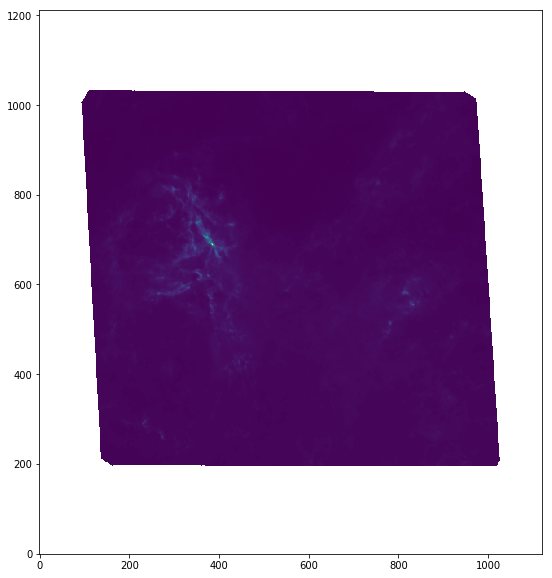

In [64]:
figure(figsize=(10,10))
imshow(im,origin='bottom')

In [65]:
#Cut the map
input = path + 'HGBS_' + name + '_column_density_map_rebin_rot.fits'
output = path + 'HGBS_' + name + '_column_density_map_rebin_rot_cut.fits'
coords = np.array([149,232,870,956])
#coords = np.array([171,439,470,897])
subfits(input,output,coords)

Dimensions 722 725


In [76]:
#Read map
HDU = fits.open(path + 'HGBS_' + name + '_column_density_map_rebin_rot_cut.fits')
im = HDU[0].data
header = HDU[0].header

INFO: Auto-setting vmin to  1.302e+19 [aplpy.core]
INFO: Auto-setting vmax to  2.760e+22 [aplpy.core]


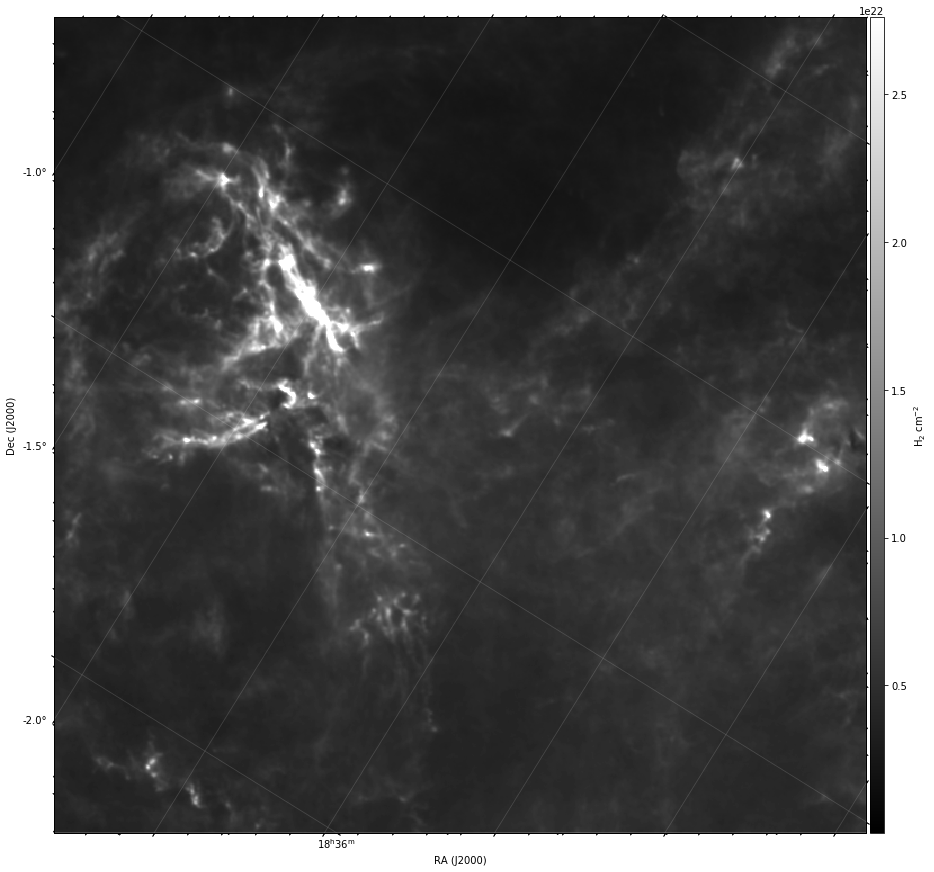

In [67]:
fig_all = plt.figure(1, figsize=(15,15))
fig = aplpy.FITSFigure(path + 'HGBS_' + name + '_column_density_map_rebin_rot_cut.fits',figure=fig_all)
fig.show_colorscale(cmap='gray')
#fig.tick_labels.set_xformat('hh')
fig.tick_labels.set_yformat('dd.d')
#fig.ticks.set_xspacing(15)  # degrees
fig.ticks.set_yspacing(0.5)  # degrees
fig.add_colorbar()
fig.add_grid()
fig.grid.set_alpha(0.15)
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')

In [77]:
#Resolution in arcmin
reso = HDU[0].header['CDELT2'] * 60.

meanim = np.mean(im)
na = im.shape[1]
nb = im.shape[0]
imzm = im - meanim

#Apodization
tapper = apodize(nb,na,0.98)
imt = imzm *tapper
newdim = np.array((800,800))
imr = padding(imt,newdim[0],newdim[1])

#Fourier power spectrum
tab_k, spec_k = powspec(imr, reso=reso)

#noise = S1a[0,20]

In [78]:
#Set a list of q
q=[]
q=[2.5]*26

#Wavelet power spectrum
wt, S11a, wav_k, S1a, q = fan_trans(im, reso=reso, q=q, qdyn=True, skewl=0.4, arrdim = newdim, smooth=False, angular=False, apodize=.98)

800 800


Text(0.5, 1.0, 'Beam power spectrum')

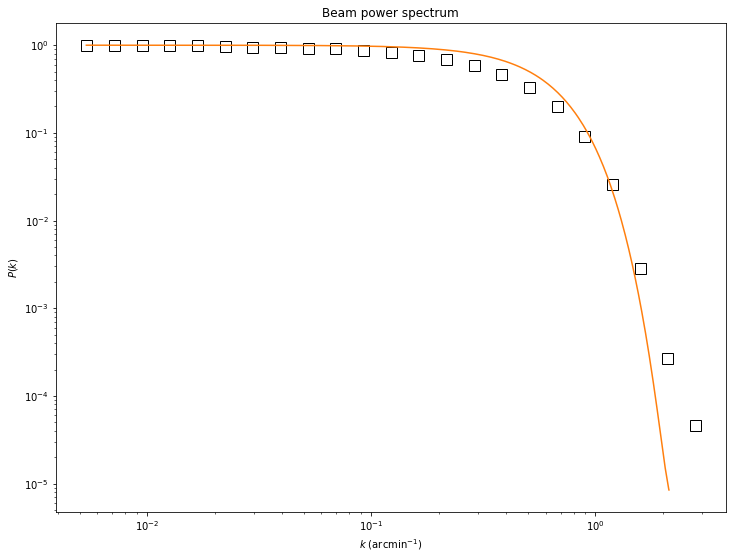

In [79]:
#Wavelet power spectrum of the telescope beam

beam = fits.open('/user/workdir/albouyg/Gouldbelt/empiral_spire_beam_500.fits')[0].data
beamr = padding(beam,newdim[0],newdim[1])

Bwt, BS11a, Bwav_k, BS1a, Bq = fan_trans(beamr, reso=reso, q=0, smooth=False)
del Bwt, BS11a, Bwav_k, Bq

tab_k, spec_beam2 = powspec(beamr,reso)
spec_beamn2 = spec_beam2 / spec_beam2[0]

#Spectrum normalisation
BS1an = BS1a / BS1a[3]
BS1an[:3] = 1.0

#Beam simulation
Sbeam = gauss_beam(36.9 / (60.*reso),newdim[0],newdim[1],FWHM=True)
tab_k, spec_beam = powspec(Sbeam,reso)
spec_beamn = spec_beam / spec_beam[0]

plt.figure(figsize(12,9))
plt.plot(wav_k, BS1an,'s', markersize = 11, markerfacecolor='none', markeredgecolor='black')
plt.plot(tab_k, spec_beamn)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ (arcmin$^{-1}$)')
plt.ylabel(r'$P(k)$')
plt.title('Beam power spectrum')

Power law fit
A, Gamma =  4.960202115232062e+42 -1.8761395750828191
Uncertainties =  1.1342378243042541 0.06757888729393204


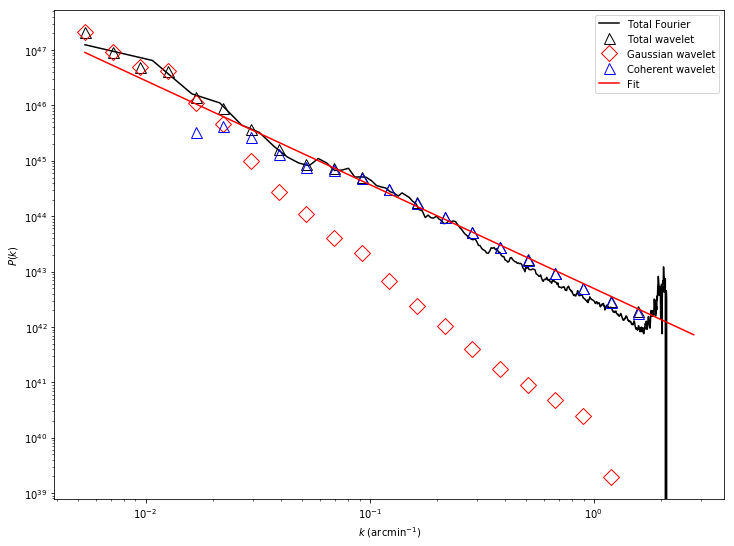

In [84]:
Noise = spec_k[-1]

#Power spectra fits
A, cov = np.polyfit(np.log(wav_k[8:18]), np.log(S1a[0,8:18]/BS1an[8:18]),deg=1,cov=True)
fit = np.exp(A[1])*wav_k**A[0]
print('Power law fit')
print('A, Gamma = ', np.exp(A[1]), A[0])
print('Uncertainties = ', np.exp(np.sqrt(np.diag(cov)[1])), np.sqrt(np.diag(cov)[0]))

plt.figure(figsize(12,9))
plt.plot(tab_k, (spec_k-Noise)/spec_beamn, color='black',label=r'Total Fourier')
plt.plot(wav_k, (S1a[0,:]-Noise)/BS1an,'^', markersize = 11, markerfacecolor='none', markeredgecolor='black', label='Total wavelet')
plt.plot(wav_k, (S1a[2,:]-Noise)/BS1an,'D', markersize = 11, markerfacecolor='none', markeredgecolor='red', label='Gaussian wavelet')
plt.plot(wav_k, (S1a[1,:]-Noise)/BS1an,'^', markersize = 11, markerfacecolor='none', markeredgecolor='blue', label='Coherent wavelet')
plt.plot(wav_k, fit, color='red',label=r'Fit')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ (arcmin$^{-1}$)')
plt.ylabel(r'$P(k)$')
plt.legend()

Text(0.5, 1.0, 'Scale-free fractal simulation')

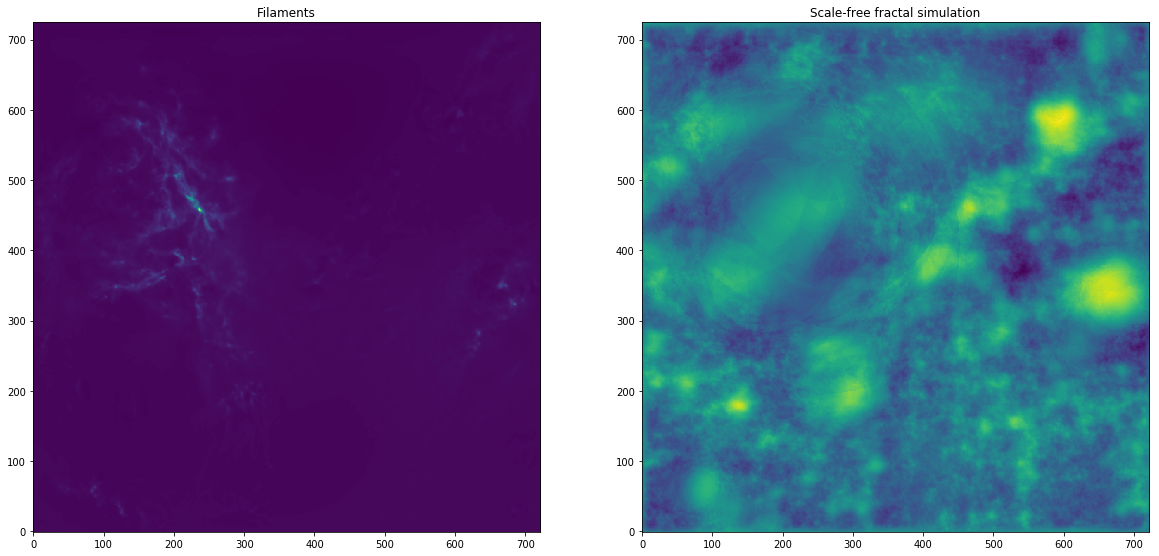

In [86]:
#Image reconstruction from the segmented wavelet coefficients
M=np.size(wav_k)
filaments = np.sum(wt[M:2*M+5,:,:].real,axis=0)
scale_free = np.sum(wt[2*M+5:3*M,:,:].real,axis=0)

fits.writeto(path + 'HGBS_' + name + '_column_density_map_reconst_filaments.fits', filaments, overwrite=True)
fits.writeto(path + 'HGBS_' + name + '_column_density_map_reconst_scale_free.fits', scale_free, overwrite=True)

#Plot images
figure(figsize=(20,10))
plt.subplot(1,2,1)
imshow(filaments,origin='bottom')
plt.title('Filaments')

plt.subplot(1,2,2)
imshow(scale_free,origin='bottom')
plt.title('Scale-free fractal simulation')